In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
ames_data = pd.read_csv("train.csv")

ames_data.columns = ames_data.columns.map(lambda x: str(x.replace(' ', '_')))

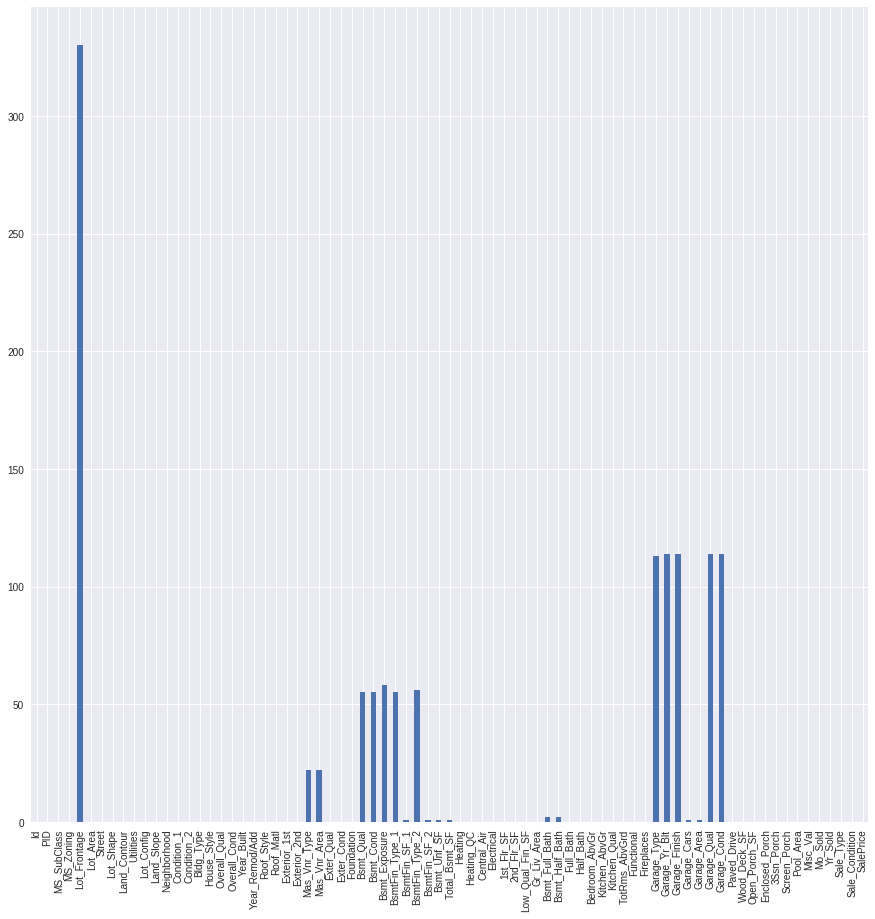

In [3]:
ames_data.Sale_Condition.describe()
ames_data.Sale_Condition.isnull().sum()
ames_data = ames_data.drop(["Alley",'Fireplace_Qu','Pool_QC','Fence', 'Misc_Feature'], axis = 1)

missing_data = ames_data.isnull().sum()

fig, ax = plt.subplots(figsize=(15,15))
missing_data.plot(kind = 'bar')

In [4]:
ames_data.Sale_Condition.value_counts()

Normal     1696
Partial     164
Abnorml     132
Family       29
Alloca       19
AdjLand      11
Name: Sale_Condition, dtype: int64

In [5]:
ames_data.Sale_Condition.replace({'Normal': 0, 'Partial': 0, 'Abnorml': 1, 'Family': 0, 'Alloca': 0, 'AdjLand': 0}, inplace=True)

In [6]:
ames_data.Sale_Condition.value_counts()

0    1919
1     132
Name: Sale_Condition, dtype: int64

In [7]:
ames_data.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,...,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,109,533352170,60,RL,nan,13517,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,0,130500
1,544,531379050,60,RL,43.000,11492,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,4,2009,WD,0,220000
2,153,535304180,20,RL,68.000,7922,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,1,2010,WD,1,109000
3,318,916386060,60,RL,73.000,9802,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,0,174000
4,255,906425045,50,RL,82.000,14235,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,0,138500


In [9]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

ames_data["Lot_Frontage"] = ames_data.groupby("Neighborhood")["Lot_Frontage"].transform(lambda x: x.fillna(x.median()))

In [15]:
#clean up all the string data. 

def string_cleaning(df):
    return df.replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'Av': 3, 'Mn': 2, 'No': 1,\
                            'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 4, 'LwQ': 2, 'Unf': 1, 'Typ': 5, 'Min1': 4,\
                            'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sal': 0,'Fin': 3, 'RFn': 2, 'Unf': 1,\
                            'AllPub': 1, 'Pave': 1, 'Grvl': 0, 'AllPub': 4, 'NoSewr':3, 'NoSeWa':2, "ELO":1 }, inplace=True)
string_cleaning(ames_data)

string_cleaning_tf = FunctionTransformer(string_cleaning, validate=False)
ames_data.head()

#dont forget the .to_frame() method. 

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,...,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,109,533352170,60,RL,70.000,13517,1,IR1,Lvl,4,...,0,0,0,0,0,3,2010,WD,0,130500
1,544,531379050,60,RL,43.000,11492,1,IR1,Lvl,4,...,0,0,0,0,0,4,2009,WD,0,220000
2,153,535304180,20,RL,68.000,7922,1,Reg,Lvl,4,...,0,0,0,0,0,1,2010,WD,1,109000
3,318,916386060,60,RL,73.000,9802,1,Reg,Lvl,4,...,0,0,0,0,0,4,2010,WD,0,174000
4,255,906425045,50,RL,82.000,14235,1,IR1,Lvl,4,...,0,0,0,0,0,3,2010,WD,0,138500


In [16]:
# Replacing missing data with 0 (Since No garage = no cars)

def garage_cleaner(df):
    for col in ('Garage_Yr_Blt', 'Garage_Area', 'Garage_Cars'): 
        df[col] = df[col].fillna(0)

garage_cleaner(ames_data)
garage_cleaner_tf = FunctionTransformer(garage_cleaner, validate=False)

In [17]:
garage_cleaner(ames_data)

In [18]:
ames_data.Garage_Qual.unique()

array([  3.,   2.,  nan,   4.,   5.,   1.])

In [19]:
# if a basement has 0 sqft, baths, half baths/baths, and unfinished area there is no basement. 
def no_basement(df):
    for col in ('BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF','Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath'):
        df[col] = df[col].fillna((0))
        
no_basement(ames_data)   

no_basement_tf = FunctionTransformer(no_basement, validate=False)

In [20]:
ames_data.BsmtFin_Type_2.unique()

array([  1.,   4.,  nan,   3.,   5.,   2.])

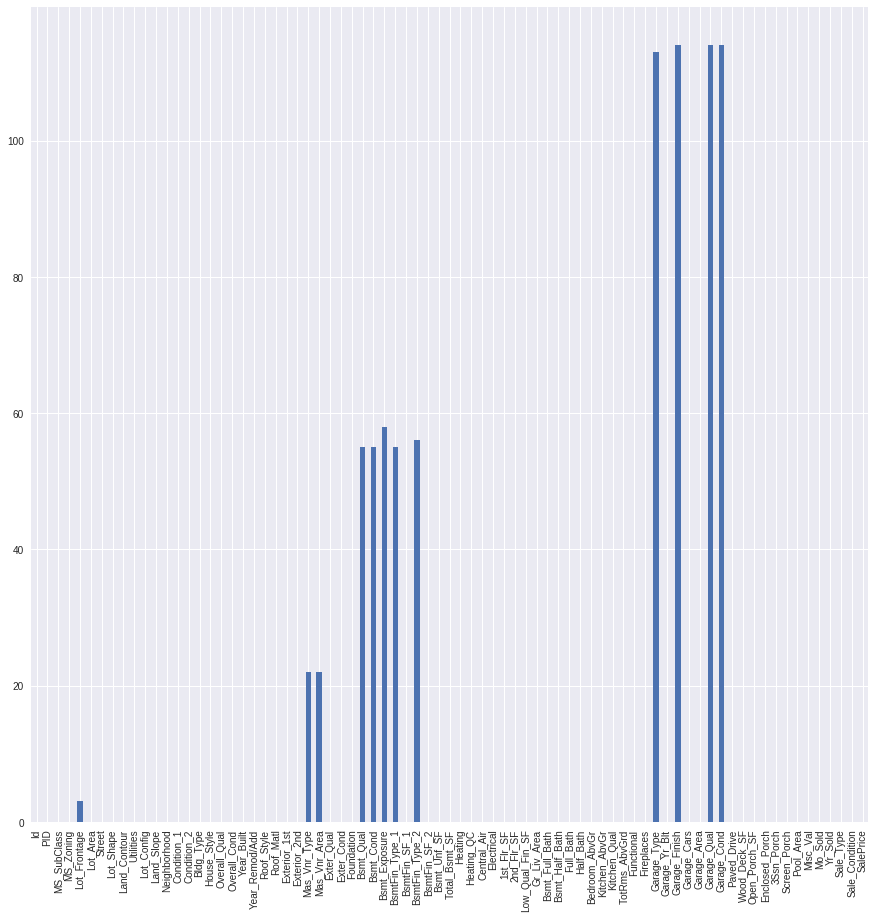

In [21]:
#Lets see how the missing data is looking now.
missing_data = ames_data.isnull().sum()

fig, ax = plt.subplots(figsize=(15,15))
missing_data.plot(kind = 'bar')

# Need to get rid of the outliers and change some of the data types


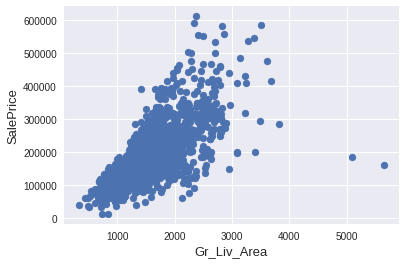

In [22]:
fig, ax = plt.subplots()
ax.scatter(ames_data['Gr_Liv_Area'], ames_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr_Liv_Area', fontsize=13)
plt.show()

So it appears that there are two outliers in the bottom right of the graph. It should be safe to get rid of these two data points.  



In [23]:
ames_data = ames_data.drop(ames_data[(ames_data['Gr_Liv_Area']>4000) & (ames_data['SalePrice']<300000)].index)

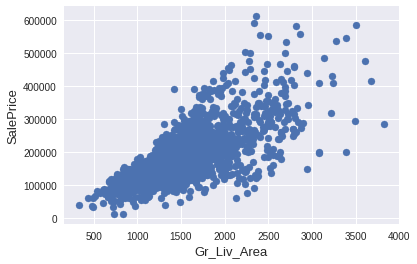

In [24]:
#checking our work
fig, ax = plt.subplots()
ax.scatter(ames_data['Gr_Liv_Area'], ames_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr_Liv_Area', fontsize=13)
plt.show()

Looks good. 


In [25]:
ames_data["Total_SF"] = ames_data['Gr_Liv_Area'] + ames_data["Total_Bsmt_SF"] + ames_data["Garage_Area"] + ames_data['Wood_Deck_SF']\
    + ames_data["Open_Porch_SF"] + ames_data['Enclosed_Porch'] + ames_data['3Ssn_Porch'] + ames_data['Screen_Porch']\
    + ames_data['Pool_Area']

ames_data["Total_Bathrooms"] = ames_data['Bsmt_Full_Bath'] + ames_data['Bsmt_Half_Bath'] + ames_data['Full_Bath'] + ames_data['Half_Bath']


ames_data['Quality_Average_5'] = (ames_data['Exter_Qual'] + ames_data['Exter_Cond'] + ames_data['Bsmt_Qual'] + ames_data['Bsmt_Cond'] + ames_data['Bsmt_Exposure'] + ames_data['BsmtFin_Type_1'] + ames_data['BsmtFin_Type_2'] + ames_data['Heating_QC'] + ames_data['Kitchen_Qual'] + ames_data['Garage_Cond'] + ames_data['Garage_Qual']).mean()

ames_data['Quality_Average_10'] = (ames_data["Overall_Qual"] + ames_data['Overall_Cond']).mean()

# Lets check and see what variables are correlated with Sale Condition.


In [27]:
ames_data.corr()['Sale_Condition'].sort_values(ascending = False)

Sale_Condition        1.000
PID                   0.060
Enclosed_Porch        0.055
Low_Qual_Fin_SF       0.051
Kitchen_AbvGr         0.051
Mo_Sold               0.043
Id                    0.022
BsmtFin_Type_2        0.020
Street                0.015
MS_SubClass           0.015
BsmtFin_SF_2          0.013
Screen_Porch          0.012
Open_Porch_SF         0.007
Bedroom_AbvGr         0.001
Quality_Average_5     0.000
Quality_Average_10   -0.000
Bsmt_Half_Bath       -0.002
Yr_Sold              -0.008
Lot_Frontage         -0.012
3Ssn_Porch           -0.013
Pool_Area            -0.016
Lot_Area             -0.017
Bsmt_Unf_SF          -0.020
Misc_Val             -0.022
Bsmt_Exposure        -0.028
TotRms_AbvGrd        -0.029
1st_Flr_SF           -0.030
Exter_Cond           -0.034
Mas_Vnr_Area         -0.034
Bsmt_Full_Bath       -0.035
BsmtFin_SF_1         -0.041
2nd_Flr_SF           -0.045
Garage_Qual          -0.049
Gr_Liv_Area          -0.057
Total_Bsmt_SF        -0.058
Garage_Cond         

# Lets start the classification - KNN is our only known classifier.



In [28]:
y = ames_data['Sale_Condition']

features = ['Low_Qual_Fin_SF', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'Yr_Sold']

X = ames_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [33]:
imputer = Imputer()

ss = StandardScaler()

knn = KNeighborsClassifier()

pipe = Pipeline([
    
  
    ('imputer', imputer), #needs to happen before scaling because it takes care of the nulls
    ('ss', ss),
    ('knn', knn)
])

params = {}

gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_


In [34]:
test = pd.read_csv('test.csv', index_col='Id')
test.columns = test.columns.map(lambda x: str(x.replace(' ', '_')))
test.head()

0.9375


{}

In [43]:
def string_cleaning(df):
    return df.replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'Av': 3, 'Mn': 2, 'No': 1,\
                            'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 4, 'LwQ': 2, 'Unf': 1, 'Typ': 5, 'Min1': 4,\
                            'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sal': 0,'Fin': 3, 'RFn': 2, 'Unf': 1,\
                            'AllPub': 1, 'Pave': 1, 'Grvl': 0, 'AllPub': 4, 'NoSewr':3, 'NoSeWa':2, "ELO":1 }, inplace = True)
string_cleaning(test)

In [44]:
Xs_test = test[features]
Xs_test.head()

,Low_Qual_Fin_SF,Mo_Sold,Overall_Cond,Overall_Qual,Yr_Sold
Id,,,,,
2658,0,4,8,6,2006
2718,0,8,4,5,2006
2414,0,9,5,7,2006
1989,0,7,6,5,2007
625,0,7,5,6,2009


In [45]:
predictions = gs.predict(Xs_test)

In [46]:
test["Sale_Condition"] = predictions

In [47]:
test[['Sale_Condition']].to_csv('submission_19.csv', index = True)